In [3]:
import math
import pandas as pd
from torch import nn
import torch

In [21]:
def read_data(file):
    df = pd.read_csv(file, parse_dates=["datetime"])
    df = df.set_index("datetime")

    # Sort by datetime to ensure proper time series order
    df = df.sort_index()

    # Convert boolean fields to proper boolean types
    df['holiday'] = df['holiday'].astype(bool)
    df['workingday'] = df['workingday'].astype(bool)

    # Handle any missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Create additional time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Cyclical encoding for better periodicity capture
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lag features
    for lag in [1, 24, 168]:  # 1hr, 1day, 1week
        df[f'lag_{lag}'] = df['count'].shift(lag)
    
    # Rolling statistics
    for window in [24, 168]:  # 1day, 1week
        df[f'rolling_mean_{window}'] = df['count'].rolling(window).mean()
        df[f'rolling_std_{window}'] = df['count'].rolling(window).std()
    
    # Handle missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

train_df = read_data("data/train.csv")
train_df

C:\Users\gavan\AppData\Local\Temp\ipykernel_22688\3162104986.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\gavan\AppData\Local\Temp\ipykernel_22688\3162104986.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,day_cos,month_sin,month_cos,lag_1,lag_24,lag_168,rolling_mean_24,rolling_std_24,rolling_mean_168,rolling_std_168
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,False,False,1,9.84,14.395,81,0.0000,3,13,...,-0.222521,5.000000e-01,0.866025,16.0,16.0,16.0,41.041667,34.292196,56.458333,51.220768
2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80,0.0000,8,32,...,-0.222521,5.000000e-01,0.866025,16.0,16.0,16.0,41.041667,34.292196,56.458333,51.220768
2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80,0.0000,5,27,...,-0.222521,5.000000e-01,0.866025,40.0,16.0,16.0,41.041667,34.292196,56.458333,51.220768
2011-01-01 03:00:00,1,False,False,1,9.84,14.395,75,0.0000,3,10,...,-0.222521,5.000000e-01,0.866025,32.0,16.0,16.0,41.041667,34.292196,56.458333,51.220768
2011-01-01 04:00:00,1,False,False,1,9.84,14.395,75,0.0000,0,1,...,-0.222521,5.000000e-01,0.866025,13.0,16.0,16.0,41.041667,34.292196,56.458333,51.220768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,False,True,1,15.58,19.695,50,26.0027,7,329,...,-0.222521,-2.449294e-16,1.000000,569.0,353.0,402.0,220.416667,186.637970,210.892857,170.118980
2012-12-19 20:00:00,4,False,True,1,14.76,17.425,57,15.0013,10,231,...,-0.222521,-2.449294e-16,1.000000,336.0,268.0,268.0,219.291667,186.419928,210.732143,170.077456
2012-12-19 21:00:00,4,False,True,1,13.94,15.910,61,15.0013,4,164,...,-0.222521,-2.449294e-16,1.000000,241.0,168.0,202.0,219.291667,186.419928,210.529762,170.108135


In [22]:
print(train_df.columns)

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'lag_1', 'lag_24', 'lag_168',
       'rolling_mean_24', 'rolling_std_24', 'rolling_mean_168',
       'rolling_std_168'],
      dtype='object')


In [5]:
# Load the dataset
train_df = read_data("data/train.csv")
test_df = read_data("data/test.csv")

train_df.head(3)

C:\Users\gavan\AppData\Local\Temp\ipykernel_22688\4258966883.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
C:\Users\gavan\AppData\Local\Temp\ipykernel_22688\4258966883.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day_of_week,month
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,False,False,1,9.84,14.395,81,0.0,3,13,16,0,5,1
2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80,0.0,8,32,40,1,5,1
2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80,0.0,5,27,32,2,5,1


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1)]

In [23]:
class TransformerTimeSeriesModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        context_length: int = 168,
        prediction_length: int = 1,
        output_variance: bool = True,
    ):
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.d_model = d_model
        self.output_variance = output_variance

        # self.input_proj = nn.Linear(input_size, d_model)
        # Multi-layer input projection
        self.input_proj = nn.Sequential(
            nn.Linear(input_size, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model)
        )
        self.pos_enc = PositionalEncoding(d_model, max_len=context_length)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        out_dim = prediction_length * (2 if output_variance else 1)
        self.head = nn.Linear(d_model, out_dim)

    def forward(self, x):
        # x: (B, context_length, 1)
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)  # (B, T, D)
        # Use representation of last time step
        h_last = h[:, -1, :]  # (B, D)
        out = self.head(h_last)  # (B, pred_len*(...))
        if self.output_variance:
            mean, log_var = out.chunk(2, dim=-1)
            mean = mean.view(-1, self.prediction_length)
            log_var = log_var.view(-1, self.prediction_length)
            return mean, log_var.clamp(-7, 7)
        else:
            mean = out.view(-1, self.prediction_length)
            return mean, None

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

context_length = 24
prediction_length = 1

model = TransformerTimeSeriesModel(
    input_size=1,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    context_length=context_length,
    prediction_length=prediction_length,
    output_variance=True,
).to(device)

c:\Users\gavan\уник\ACPI\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## Train the model

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Prepare training data
def create_sequences(data, context_length, prediction_length):
    """Create input-output sequences for training"""
    X, y = [], []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i + context_length])
        y.append(data[i + context_length:i + context_length + prediction_length])
    return np.array(X), np.array(y)

# Extract target column (assuming 'count' or similar target variable)
target_col = 'count'  # Adjust based on your dataset
train_data = train_df[target_col].values

# Create sequences
X_train, y_train = create_sequences(train_data, context_length, prediction_length)

# Convert to tensors
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Add feature dimension
y_train = torch.FloatTensor(y_train)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

def train_model_enhanced(model, train_loader, val_loader, num_epochs=50):
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            mean_pred, log_var_pred = model(batch_x)
            
            # Enhanced loss with uncertainty
            if log_var_pred is not None:
                var_pred = torch.exp(log_var_pred)
                # Negative log-likelihood + regularization
                nll = 0.5 * (torch.log(2 * np.pi * var_pred) + 
                            (batch_y - mean_pred)**2 / var_pred)
                loss = nll.mean() + 0.01 * log_var_pred.mean()  # Regularize variance
            else:
                loss = nn.MSELoss()(mean_pred, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                mean_pred, log_var_pred = model(batch_x)
                
                if log_var_pred is not None:
                    var_pred = torch.exp(log_var_pred)
                    nll = 0.5 * (torch.log(2 * np.pi * var_pred) + 
                                (batch_y - mean_pred)**2 / var_pred)
                    loss = nll.mean()
                else:
                    loss = nn.MSELoss()(mean_pred, batch_y)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print("Early stopping triggered")
                break
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
print("Training completed!")

Training completed!


In [26]:
class TransformerACPIWrapper:
    def __init__(self, transformer_model, device, context_length):
        self.model = transformer_model
        self.device = device
        self.context_length = context_length
        self.model.eval()

    def predict(self, X):
        """
        Predict using the transformer model for ACPI
        X: numpy array of shape (n_samples, context_length)
        Returns: numpy array of predictions
        """
        # Convert to tensor and add feature dimension
        X_tensor = torch.FloatTensor(X).unsqueeze(-1).to(self.device)

        with torch.no_grad():
            mean_pred, log_var_pred = self.model(X_tensor)
            # Return mean predictions for ACPI
            return mean_pred.cpu().numpy().flatten()

In [11]:
# Prepare test data for ACPI
def prepare_acpi_data(data, context_length, test_split=0.3, cal_split=0.5):
    """Prepare data splits for ACPI training"""
    # Create sequences
    X, y = create_sequences(data, context_length, prediction_length=1)

    # Split into train/test
    n_test = int(len(X) * test_split)
    X_temp, X_test = X[:-n_test], X[-n_test:]
    y_temp, y_test = y[:-n_test], y[-n_test:]

    # Split remaining into train/calibration
    n_cal = int(len(X_temp) * cal_split)
    X_train, X_cal = X_temp[:-n_cal], X_temp[-n_cal:]
    y_train, y_cal = y_temp[:-n_cal], y_temp[-n_cal:]

    return X_train, X_cal, X_test, y_train.flatten(), y_cal.flatten(), y_test.flatten()

# Prepare data
X_train_acpi, X_cal, X_test, y_train_acpi, y_cal, y_test = prepare_acpi_data(
    train_data, context_length
)

In [28]:
# Create transformer wrapper for ACPI
transformer_wrapper = TransformerACPIWrapper(model, device, context_length)

# Initialize ACPI with the transformer model
from acpi import ACPI
from acpi.utils import compute_coverage

alpha = 0.1  # 90% prediction intervals

acpi = ACPI(
    model_cali=transformer_wrapper,
    n_estimators=200,
    max_depth=15,
    min_node_size=10
)

# Fit ACPI on calibration data
acpi.fit(X_cal, y_cal, nonconformity_func=None)

# Fit calibration
acpi.fit_calibration(X_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)

# Generate prediction intervals
y_lower, y_upper = acpi.predict_pi(X_test, method='qrf')

# Compute coverage
coverage = compute_coverage(y_test, y_lower, y_upper)
print(f'ACPI Coverage: {coverage:.4f}')
print(f'Target Coverage: {1-alpha:.4f}')

100%|██████████| 50/50 [09:56<00:00, 11.92s/it]


ACPI Coverage: 0.8613
Target Coverage: 0.9000


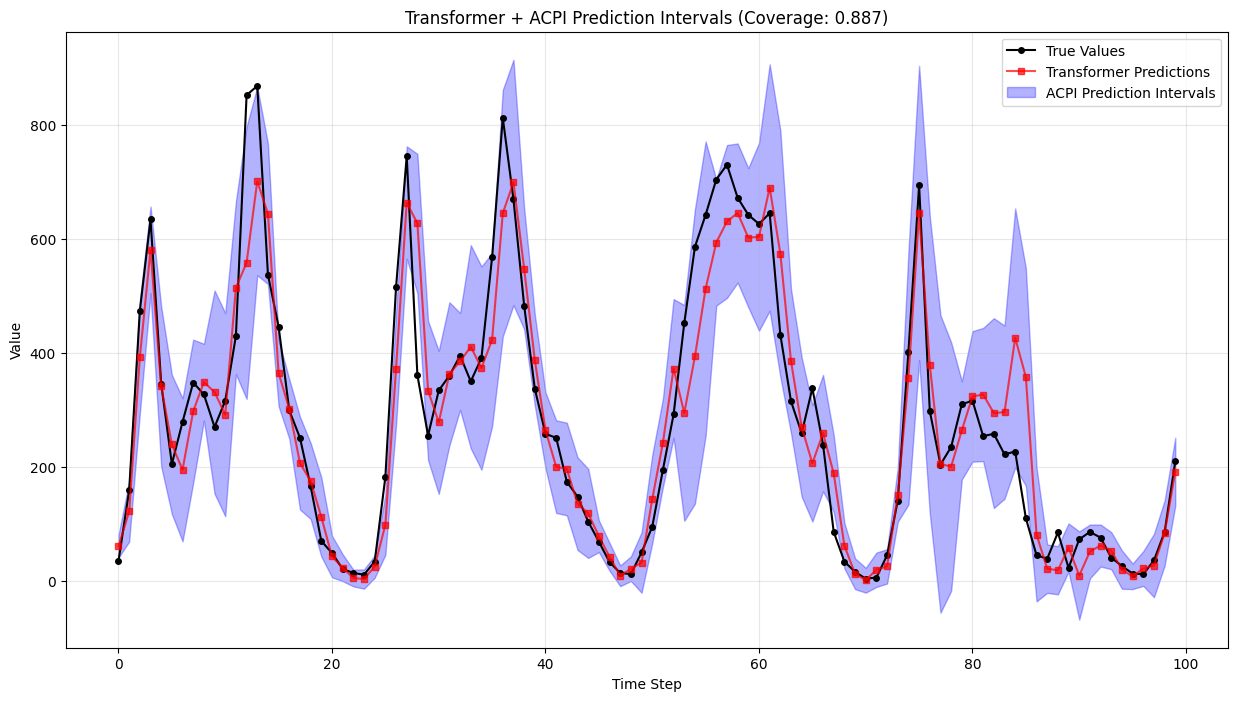

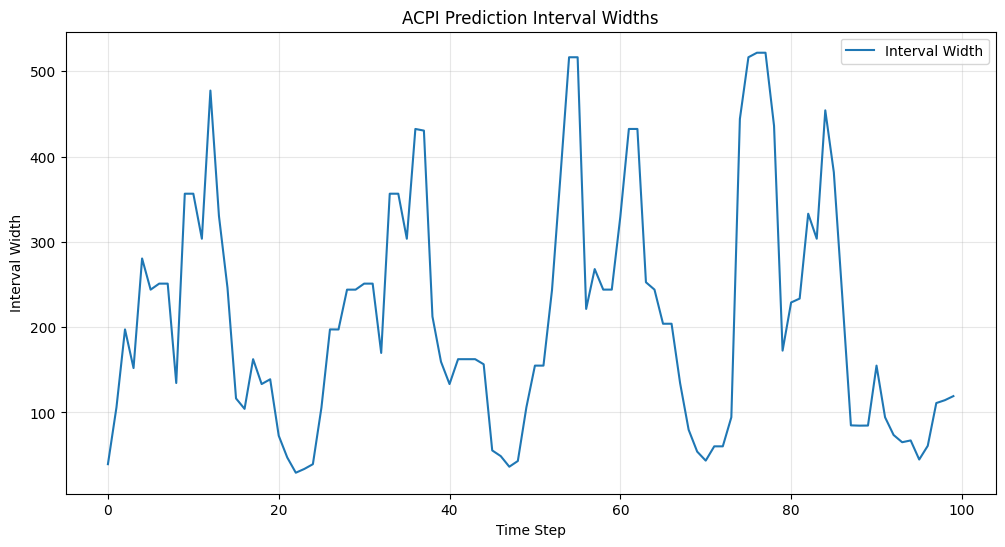

In [ ]:
# Visualize results
import matplotlib.pyplot as plt

# Get transformer predictions for comparison
transformer_preds = transformer_wrapper.predict(X_test)

# Plot first 100 predictions
n_plot = min(100, len(y_test))
indices = range(n_plot)

plt.figure(figsize=(15, 8))

# Plot true values
plt.plot(indices, y_test[:n_plot], 'o-', label='True Values', color='black', markersize=4)

# Plot transformer predictions
plt.plot(indices, transformer_preds[:n_plot], 's-', label='Transformer Predictions',
         color='red', markersize=4, alpha=0.7)

# Plot ACPI prediction intervals
plt.fill_between(indices, y_lower[:n_plot], y_upper[:n_plot],
                 alpha=0.3, label='ACPI Prediction Intervals', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'Transformer + ACPI Prediction Intervals (Coverage: {coverage:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot interval widths
interval_widths = y_upper - y_lower
plt.figure(figsize=(12, 6))
plt.plot(interval_widths[:n_plot], label='Interval Width')
plt.xlabel('Time Step')
plt.ylabel('Interval Width')
plt.title('ACPI Prediction Interval Widths')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()